# Entropy Analysis + Plots + Stats
- Do different languages have statistically significant differences in entropy?
- This affects how we analyze meaningful vs. non meaningful reviews.

In [1]:
!pip install -q pycountry langdetect scikit-posthocs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 75.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.stats as stats
import re
import nltk
from nltk.corpus import words
from collections import Counter
import math
import unicodedata
import time
from tqdm import tqdm
import pickle
from langdetect import detect
import warnings
import pycountry
from scipy import stats

In [3]:
# Import data from custom dataset
original_df = pd.read_pickle('/kaggle/input/reviews-analyzer-dataset/df_w_langs_entropies.pkl')
original_df.rename(columns={'language': 'lang_code'}, inplace=True)
original_df.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,entropy,lang_code
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1,4.262386,en
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,"Nov 09, 2015",1,4.081944,en


Get the actual names of all the languages and add a new column

In [4]:
def get_language_name(code):
    """Convert ISO 639-1 code to full language name using pycountry."""
    if code == 'unknown':
        return 'Unknown'
    try:
        # Handle cases like 'zh-cn' by taking the first part
        code = code.split('-')[0]
        lang = pycountry.languages.get(alpha_2=code)
        return lang.name if lang else code
    except AttributeError:
        return code

In [5]:
original_df['language'] = original_df['lang_code'].apply(get_language_name)
original_df.head(2)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,entropy,lang_code,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1,4.262386,en,English
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,"Nov 09, 2015",1,4.081944,en,English


In [6]:
#original_df.to_pickle('df_w_languages')

Top 10 Languages % of Total
| Language | Pct of Total |
|--|--|
|English|81.83%|
|Spanish|6.76%|
|French|2.27%|
|Somali|1.36%|
|Romanian|1.10%|
|Portuguese|1.08%|
|Catalan|1.07%|
|Afrikaans|0.87%|
|Unknown|0.50%|
|Russian|0.44%|



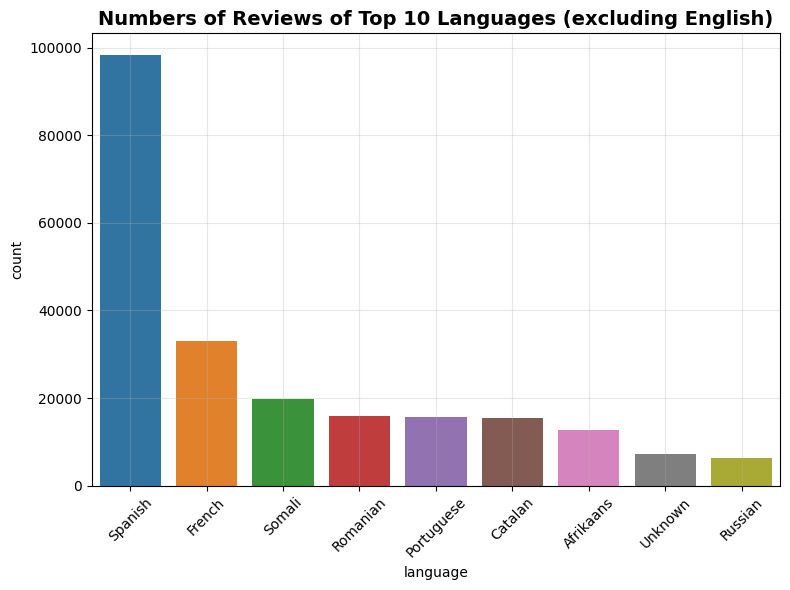

In [7]:
# Plot the counts of the top 10 languages
def count_and_plot_languages(df, top=10):
    
    lang_counts_df = df.language.value_counts().reset_index()
    n = lang_counts_df['count'].sum()
    # Make markdown chart
    table = f'| Language | Pct of Total |\n'
    table += f'|--|--|\n'
    for i in range(10):
        table += f'|{lang_counts_df.iloc[i,0]}|{lang_counts_df.iloc[i,1]/n:.2%}|\n'
    print("Top 10 Languages % of Total")
    print(table)
    
    plt.figure(figsize=(8,6))
    sns.barplot(x='language', y='count', data=lang_counts_df.iloc[1:10])
    plt.title('Numbers of Reviews of Top 10 Languages (excluding English)', fontweight='bold', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('review_lang_dist.png')
    plt.show()

count_and_plot_languages(original_df, 10)

Top 10 Languages % of Total
| Language | Pct of Total |
|--|--|
|English|81.83%|
|Spanish|6.76%|
|French|2.27%|
|Somali|1.36%|
|Romanian|1.10%|
|Portuguese|1.08%|
|Catalan|1.07%|
|Afrikaans|0.87%|
|Unknown|0.50%|
|Russian|0.44%|

In [8]:
original_df.language.value_counts().reset_index().iloc[0:25,:].to_markdown()

'|    | language                |   count |\n|---:|:------------------------|--------:|\n|  0 | English                 | 1190455 |\n|  1 | Spanish                 |   98361 |\n|  2 | French                  |   33012 |\n|  3 | Somali                  |   19826 |\n|  4 | Romanian                |   15950 |\n|  5 | Portuguese              |   15670 |\n|  6 | Catalan                 |   15516 |\n|  7 | Afrikaans               |   12633 |\n|  8 | Unknown                 |    7202 |\n|  9 | Russian                 |    6333 |\n| 10 | German                  |    6304 |\n| 11 | Italian                 |    4217 |\n| 12 | Norwegian               |    3629 |\n| 13 | Chinese                 |    3340 |\n| 14 | Polish                  |    3179 |\n| 15 | Tagalog                 |    2219 |\n| 16 | Welsh                   |    2062 |\n| 17 | Swahili (macrolanguage) |    2043 |\n| 18 | Indonesian              |    1488 |\n| 19 | Dutch                   |    1484 |\n| 20 | Danish                  

| rank | language |   count |
|---|------------------------|--------|
|  1 | English                 | 1190455 |
|  2 | Spanish                 |   98361 |
|  3 | French                  |   33012 |
|  4 | Somali                  |   19826 |
|  5 | Romanian                |   15950 |
|  6 | Portuguese              |   15670 |
|  7 | Catalan                 |   15516 |\n
|  8 | Afrikaans               |   12633 |
|  9 | Unknown                 |    7202 |
|  10 | Russian                 |    6333 |
| 11 | German                  |    6304 |
| 12 | Italian                 |    4217 |
| 13 | Norwegian               |    3629 |
| 14 | Chinese                 |    3340 |
| 15 | Polish                  |    3179 |
| 16 | Tagalog                 |    2219 |
| 17 | Welsh                   |    2062 |
| 18 | Swahili (macrolanguage) |    2043 |
| 19 | Indonesian              |    1488 |
| 20 | Dutch                   |    1484 |
| 21 | Danish                  |    1421 |
| 22 | Vietnamese              |    1356 |
| 23 | Slovenian               |    1127 |
| 24 | Korean                  |     937 |
| 25 | Czech                   |     729 |

Identify outliers and classify them as other languages along with unknown.

In [9]:
def get_lang_count_outliers(df, col='count', percentile_cutoff=95):
    # Set langcout count cutoff to a given percentile. Defult to 95
    cutoff = np.percentile(df[col], percentile_cutoff)
    print(f"\n{percentile_cutoff}th Percentile Cutoff: {cutoff:.0f} Reviews")

    main_range = df[df[col] >= cutoff]
    outliers = df[df[col] < cutoff]
    return main_range, outliers

In [10]:
filter_counts_df, outlier_counts_df = get_lang_count_outliers(
    original_df.language.value_counts().reset_index(),
    percentile_cutoff=15
)
print(f"Outlier Languages\n")
print(outlier_counts_df)


15th Percentile Cutoff: 26 Reviews
Outlier Languages

                language  count
41               Persian     24
42                  Urdu     20
43                Hebrew     10
44  Modern Greek (1453-)      4
45                 Hindi      3
46             Malayalam      3
47               Panjabi      3
48                 Tamil      1


Next, we'll look at entropy distributions overall and by language

In [11]:
def calculate_entropy(text):
    """Calculate Shannon entropy of the text to detect randomness."""
    if not text:
        return 0
    if not isinstance(text, str) or pd.isna(text):
        return 0  # Return 0 for NaN or non-string values
    text = str(text).lower()
    length = len(text)
    if length == 0:  # Handle empty strings
        return 0
    char_counts = Counter(text)
    entropy = -sum((count/length) * math.log2(count/length) for count in char_counts.values())
    return entropy

In [12]:
entropy_df = original_df.copy()
entropy_df['entropy'] = original_df['reviews'].apply(calculate_entropy)
entropy_df.head(1)

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,entropy,lang_code,language
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1,4.262386,en,English


Let's look at the top 8 languages (all of which have over 10k reviews) and look at entropy distributions

In [13]:
def plot_entropy_distributions(df, review_col='reviews', language_col='language', 
                               entropy_col='entropy', top_n=8,
                               option='box'):
    language_counts = df[language_col].value_counts()
    top_languages = language_counts.head(top_n).index
    df_top = df[df[language_col].isin(top_languages)].copy()
    # Set up subplots (2 rows, 4 columns for top 8)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten to 1D array for easier iteration
    
    # Plot entropy distribution for each language
    for i, lang in enumerate(top_languages):
        entropy_data = df_top[df_top[language_col] == lang][entropy_col]
        if option == 'histogrm':
            # Histogram with KDE
            sns.histplot(entropy_data, bins=30, ax=axes[i], color='blue', stat='density')
            axes[i].set_title(f'{lang} (N = {len(entropy_data)})')
            axes[i].set_xlabel('Entropy')
            axes[i].set_ylabel('Density')
            axes[i].grid(True, alpha=0.3)
            
            # Add mean and median lines
            mean_entropy = entropy_data.mean()
            median_entropy = entropy_data.median()
            axes[i].axvline(mean_entropy, color='red', linestyle='--', label=f'Mean = {mean_entropy:.2f}')
            axes[i].axvline(median_entropy, color='green', linestyle='--', label=f'Median = {median_entropy:.2f}')
            axes[i].legend()
            plt
        if option == 'boxplot':
            # Box plot
            sns.boxplot(y=entropy_data, ax=axes[i], color='lightblue', width=0.5)
            axes[i].set_title(f'{lang} (N = {len(entropy_data)})')
            axes[i].set_ylabel('Entropy')
            axes[i].grid(True, alpha=0.3)
            
            # Add mean as a point
            mean_entropy = entropy_data.mean()
            axes[i].plot([], [], 'ro', label=f'Mean = {mean_entropy:.2f}')  # Dummy for legend
            axes[i].axhline(mean_entropy, color='red', linestyle='--', alpha=0.5)
            axes[i].legend()

    # Adjust layout
    plt.suptitle(f'Entropy Distributions of Top {top_n} Languages', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f'entropy_{option}.png')
    plt.show()

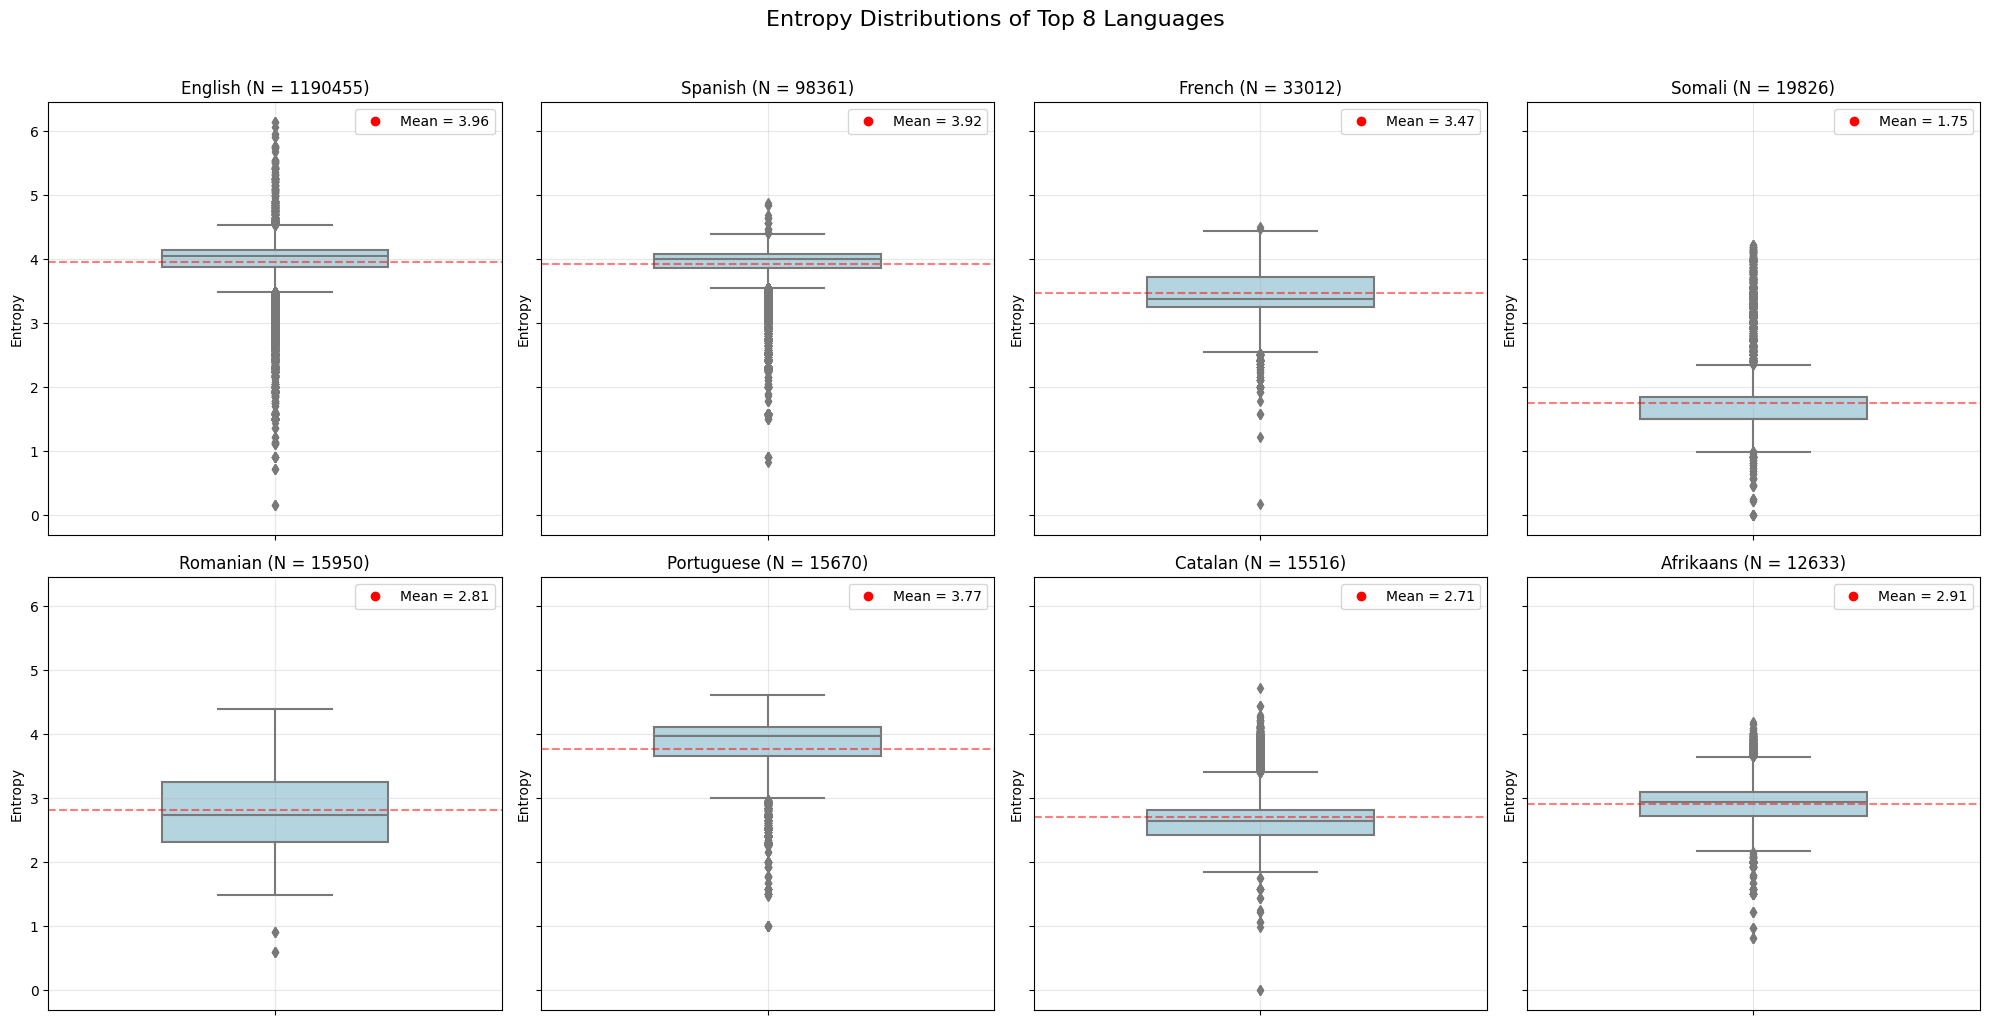

In [14]:
plot_entropy_distributions(entropy_df, review_col='reviews', 
                           language_col='language', entropy_col='entropy', 
                           top_n=8, option='boxplot')

Next identify the outlier language counts and exclude those.

#### Check assumptions
- Use Shapiro Wilk test for normality https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test
- Use Levene's test for equal variances
- Also check QQ plots

#### Test, Skewness, Kurtotis Interpretation
- Passed + Low |Skew| & |Kurtosis| (e.g., < 0.5): Practically normal, even with large N.
- Failed + High |Skew| or |Kurtosis| (e.g., > 1): Non-normal, likely skewed or heavy-tailed.
- Large N Nuance: With 1.19M samples, Anderson-Darling might "Fail" due to minor deviations, but if skew and kurtosis are near 0, it’s still "normal enough" for most purposes (e.g., ANOVA).

#### Q-Q Plots
- Straight Line: Supports normality (skew ≈ 0, kurtosis ≈ 0).
- S-Shape: Heavy tails (kurtosis > 0).
- Curved Ends: Skewed (skew ≠ 0).



Languages with 10000.0+ Reviews:
language
English       1190455
Spanish         98361
French          33012
Somali          19826
Romanian        15950
Portuguese      15670
Catalan         15516
Afrikaans       12633
Name: count, dtype: int64


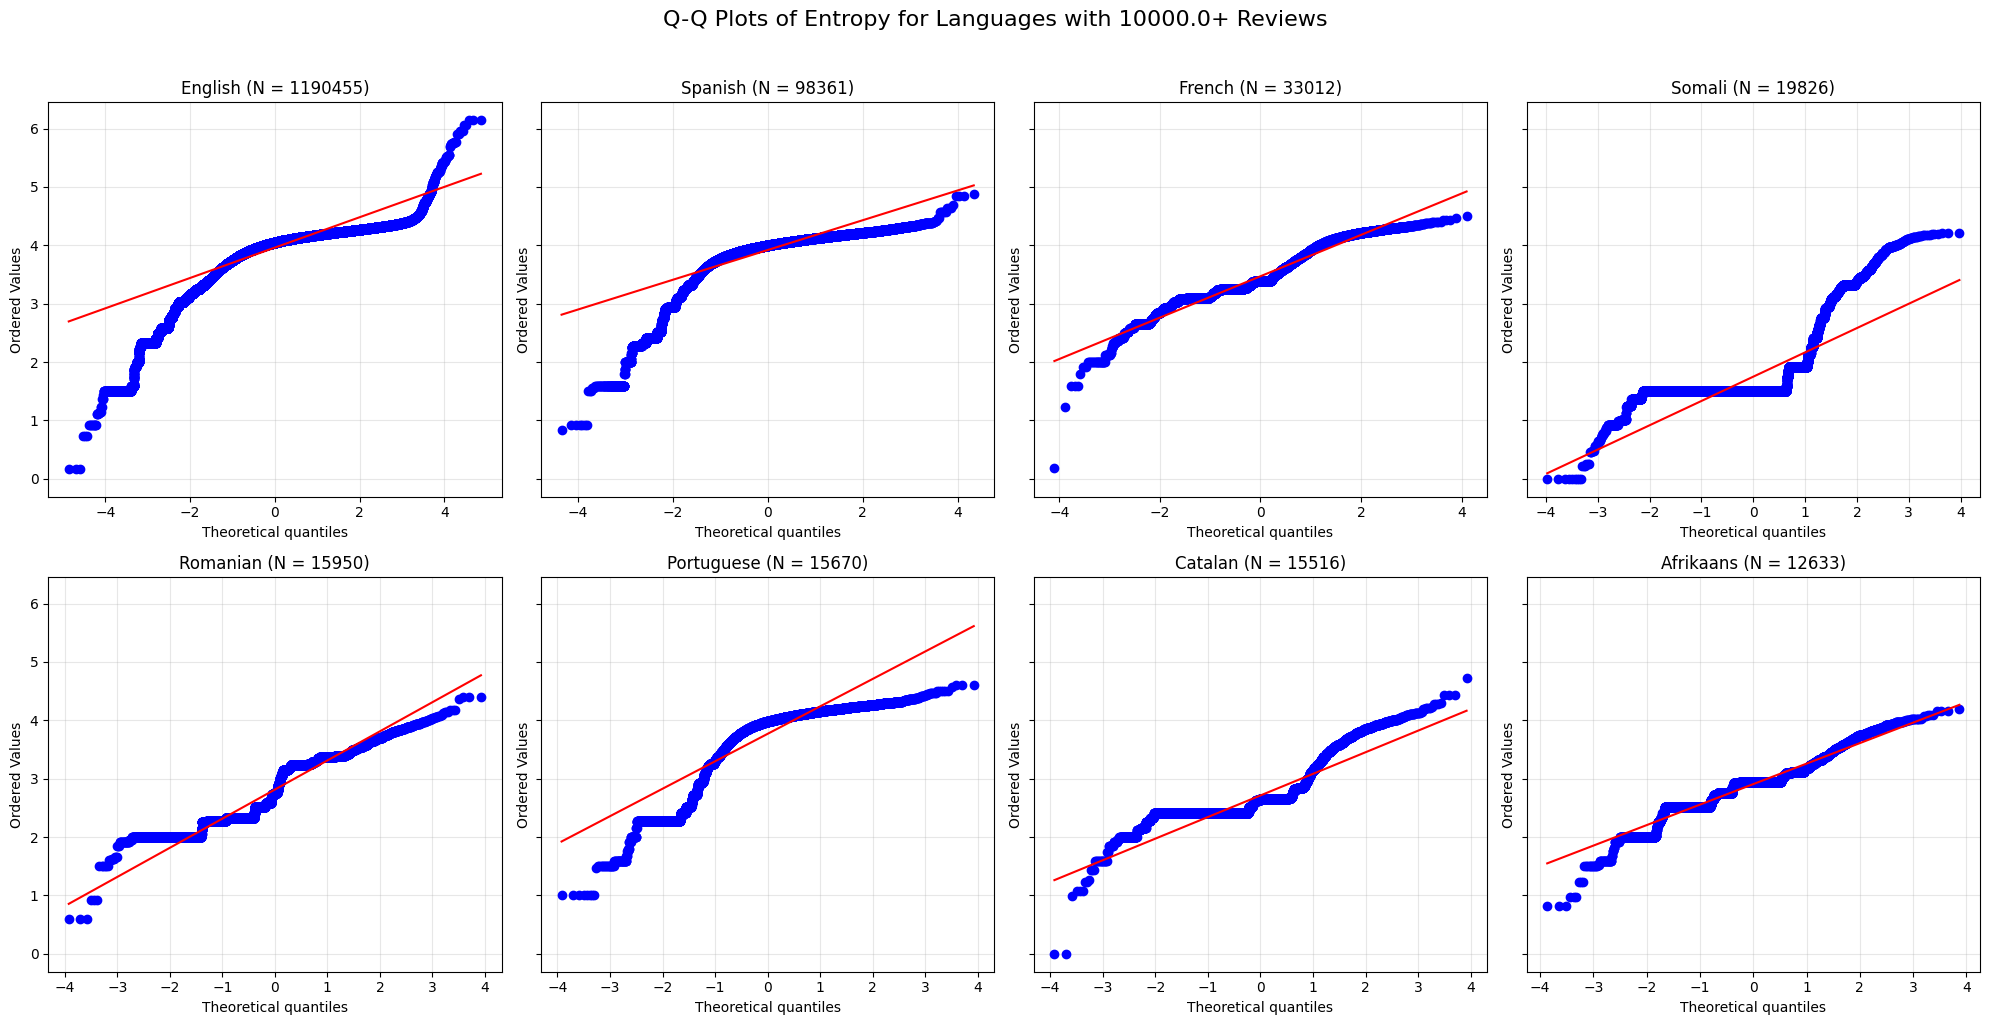


### Normality Test Results (Anderson-Darling)
| Language | Samples (N) | Normality Test | Skewness | Kurtosis |
|----------|-------------|----------------|----------|----------|
| English | 1,190,455 | Failed | -2.23 | 7.68 |
| Spanish | 98,361 | Failed | -3.04 | 12.86 |
| French | 33,012 | Failed | 0.32 | 0.19 |
| Somali | 19,826 | Failed | 2.19 | 4.21 |
| Romanian | 15,950 | Failed | 0.02 | -1.28 |
| Portuguese | 15,670 | Failed | -1.77 | 2.57 |
| Catalan | 15,516 | Failed | 1.38 | 1.77 |
| Afrikaans | 12,633 | Failed | -0.15 | 1.75 |


In [15]:
def check_entropy_normality(df, language_col='language', entropy_col='entropy', min_samples=5):
    """
    Check normality of entropy distributions by language with Q-Q plots and a Markdown table.
    
    Parameters:
    - df: DataFrame with language and entropy columns
    - language_col: Column name for language (default: 'language')
    - entropy_col: Column name for entropy (default: 'entropy')
    - min_samples: Minimum number of reviews per language to analyze (default: 5)
    """
    # Count reviews per language and filter for sufficient samples
    language_counts = df[language_col].value_counts()
    valid_languages = language_counts[language_counts >= min_samples].index
    df_filtered = df[df[language_col].isin(valid_languages)].copy()
    
    if len(valid_languages) == 0:
        print(f"No languages with {min_samples}+ reviews found.")
        return
    
    # Print summary of languages being analyzed
    print(f"Languages with {min_samples}+ Reviews:")
    print(language_counts[valid_languages])
    
    # Collect data for Markdown table
    table_data = []
    
    # Set up subplot grid (2 rows, enough columns for all languages)
    n_langs = len(valid_languages)
    cols = max(1, (n_langs + 1) // 2)  # Ensure at least 1 column
    fig, axes = plt.subplots(2, cols, figsize=(5 * cols, 10), sharey=True)
    axes = axes.flatten()  # Flatten for easier iteration
    
    # Analyze and plot for each language
    for i, lang in enumerate(valid_languages):
        entropy_data = df_filtered[df_filtered[language_col] == lang][entropy_col]
        n_samples = len(entropy_data)
        
        # Summary stats
        #print(f"\n{lang} Entropy Stats (N = {n_samples}):")
        #print(entropy_data.describe())
        
        # Anderson-Darling test
        ad_result = stats.anderson(entropy_data, dist='norm')
        critical_value = ad_result.critical_values[2]  # 5% significance level
        test_stat = ad_result.statistic
        normality_result = "Passed" if test_stat < critical_value else "Failed"
        #print(f"Anderson-Darling Test: Statistic = {test_stat:.4f}, Critical Value (5%) = {critical_value:.4f} ({normality_result})")
        
        # Skewness and Kurtosis
        skew = stats.skew(entropy_data)
        kurt = stats.kurtosis(entropy_data, fisher=True)  # Fisher definition (normal = 0)
        #print(f"Skewness = {skew:.4f} (Normal ≈ 0)")
        #print(f"Kurtosis = {kurt:.4f} (Normal ≈ 0)")
        
        # Add to table
        table_data.append([lang, n_samples, normality_result, f"{skew:.2f}", f"{kurt:.2f}"])
        
        # Q-Q plot
        stats.probplot(entropy_data, dist="norm", plot=axes[i])
        axes[i].set_title(f'{lang} (N = {n_samples})')
        axes[i].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    # Adjust layout and save
    plt.suptitle(f'Q-Q Plots of Entropy for Languages with {min_samples}+ Reviews', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('qq_grid.png', dpi=300, bbox_inches='tight')
    #print("\nQ-Q plot grid saved as 'qq_grid.png'")
    plt.show()
    
 # Print Markdown table
    print("\n### Normality Test Results (Anderson-Darling)")
    print("| Language | Samples (N) | Normality Test | Skewness | Kurtosis |")
    print("|----------|-------------|----------------|----------|----------|")
    for row in table_data:
        print(f"| {row[0]} | {row[1]:,} | {row[2]} | {row[3]} | {row[4]} |")
        
check_entropy_normality(entropy_df, min_samples=1e4)

### Normality Test Results (Anderson-Darling)
| Language | Samples (N) | Normality Test | Skewness | Kurtosis |
|----------|-------------|----------------|----------|----------|
| English | 1,190,455 | Failed | -2.23 | 7.68 |
| Spanish | 98,361 | Failed | -3.04 | 12.86 |
| French | 33,012 | Failed | 0.32 | 0.19 |
| Somali | 19,826 | Failed | 2.19 | 4.21 |
| Romanian | 15,950 | Failed | 0.02 | -1.28 |
| Portuguese | 15,670 | Failed | -1.77 | 2.57 |
| Catalan | 15,516 | Failed | 1.38 | 1.77 |
| Afrikaans | 12,633 | Failed | -0.15 | 1.75 |

Languages with 10000.0+ Reviews:
language
English       1190455
Spanish         98361
French          33012
Somali          19826
Romanian        15950
Portuguese      15670
Catalan         15516
Afrikaans       12633
Name: count, dtype: int64

Kruskal-Wallis Test: H = 217149.29, p-value = 0.0000
Significant differences in entropy medians detected.

Dunn's Post-Hoc Test (Bonferroni corrected p-values):
               Afrikaans       Catalan  English  French    Portuguese  \
Afrikaans   1.000000e+00  1.000000e+00      0.0     0.0  0.000000e+00   
Catalan     1.000000e+00  1.000000e+00      0.0     0.0  0.000000e+00   
English     0.000000e+00  0.000000e+00      1.0     0.0  0.000000e+00   
French      0.000000e+00  0.000000e+00      0.0     1.0  0.000000e+00   
Portuguese  0.000000e+00  0.000000e+00      0.0     0.0  1.000000e+00   
Romanian    1.000000e+00  1.000000e+00      0.0     0.0  0.000000e+00   
Somali      2.060380e-32  1.490080e-29      0.0     0.0  0.000000e+00   
Spanish   

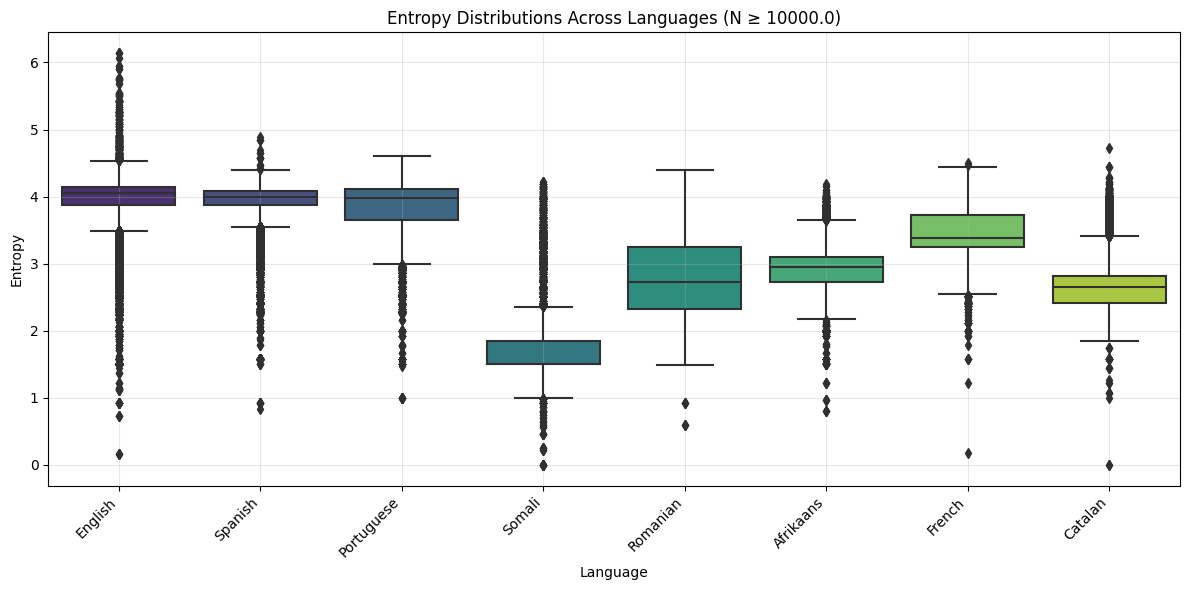


### Normality Test Results (Anderson-Darling)
| Language | Samples (N) | Normality Test | Skewness | Kurtosis |
|----------|-------------|----------------|----------|----------|
| English | 1,190,455 | Failed | -2.23 | 7.68 |
| Spanish | 98,361 | Failed | -3.04 | 12.86 |
| French | 33,012 | Failed | 0.32 | 0.19 |
| Somali | 19,826 | Failed | 2.19 | 4.21 |
| Romanian | 15,950 | Failed | 0.02 | -1.28 |
| Portuguese | 15,670 | Failed | -1.77 | 2.57 |
| Catalan | 15,516 | Failed | 1.38 | 1.77 |
| Afrikaans | 12,633 | Failed | -0.15 | 1.75 |


In [16]:
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp  # For Dunn's test

def analyze_entropy_differences(df, language_col='language', entropy_col='entropy', min_samples=5):

    # Count reviews per language and filter for sufficient samples
    language_counts = df[language_col].value_counts()
    valid_languages = language_counts[language_counts >= min_samples].index
    df_filtered = df[df[language_col].isin(valid_languages)].copy()
    
    print(f"Languages with {min_samples}+ Reviews:")
    print(language_counts[valid_languages])
    
    table_data = []
    entropy_groups = [df_filtered[df_filtered[language_col] == lang][entropy_col].values 
                      for lang in valid_languages]
    
    # Kruskal-Wallis test
    h_stat, p_kruskal = stats.kruskal(*entropy_groups)
    print(f"\nKruskal-Wallis Test: H = {h_stat:.2f}, p-value = {p_kruskal:.4f}")
    if p_kruskal < 0.05:
        print("Significant differences in entropy medians detected.")
        
        # Dunn's post-hoc test with Bonferroni correction
        dunn_results = sp.posthoc_dunn(df_filtered, val_col=entropy_col, group_col=language_col, p_adjust='bonferroni')
        print("\nDunn's Post-Hoc Test (Bonferroni corrected p-values):")
        print(dunn_results)
    else:
        print("No significant differences in entropy medians detected.")
    
    # Analyze normality and stats for each language
    for lang in valid_languages:
        entropy_data = df_filtered[df_filtered[language_col] == lang][entropy_col]
        n_samples = len(entropy_data)
        
        print(f"\n{lang} Entropy Stats (N = {n_samples:,}):")
        print(entropy_data.describe())
        
        # Anderson-Darling test
        ad_result = stats.anderson(entropy_data, dist='norm')
        critical_value = ad_result.critical_values[2]  # 5% significance level
        test_stat = ad_result.statistic
        normality_result = "Passed" if test_stat < critical_value else "Failed"
        
        # Skewness and Kurtosis
        skew = stats.skew(entropy_data)
        kurt = stats.kurtosis(entropy_data, fisher=True)
        
        # Add to table
        table_data.append([lang, n_samples, normality_result, f"{skew:.2f}", f"{kurt:.2f}"])
    
    # Box plot for visualization
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=language_col, y=entropy_col, data=df_filtered, palette='viridis')
    plt.title(f'Entropy Distributions Across Languages (N ≥ {min_samples})')
    plt.xlabel('Language')
    plt.ylabel('Entropy')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('entropy_boxplot.png', dpi=300, bbox_inches='tight')
    print("\nBox plot saved as 'entropy_boxplot.png'")
    plt.show()
    
    # Print Markdown table
    print("\n### Normality Test Results (Anderson-Darling)")
    print("| Language | Samples (N) | Normality Test | Skewness | Kurtosis |")
    print("|----------|-------------|----------------|----------|----------|")
    for row in table_data:
        print(f"| {row[0]} | {row[1]:,} | {row[2]} | {row[3]} | {row[4]} |")

analyze_entropy_differences(entropy_df, min_samples=1e4)

### Normality Test Results (Anderson-Darling)
| Language | Samples (N) | Normality Test | Skewness | Kurtosis |
|----------|-------------|----------------|----------|----------|
| English | 1,190,455 | Failed | -2.23 | 7.68 |
| Spanish | 98,361 | Failed | -3.04 | 12.86 |
| French | 33,012 | Failed | 0.32 | 0.19 |
| Somali | 19,826 | Failed | 2.19 | 4.21 |
| Romanian | 15,950 | Failed | 0.02 | -1.28 |
| Portuguese | 15,670 | Failed | -1.77 | 2.57 |
| Catalan | 15,516 | Failed | 1.38 | 1.77 |
| Afrikaans | 12,633 | Failed | -0.15 | 1.75 |

Languages with 5+ Reviews:
language
English                    1190455
Spanish                      98361
French                       33012
Somali                       19826
Romanian                     15950
Portuguese                   15670
Catalan                      15516
Afrikaans                    12633
Unknown                       7202
Russian                       6333
German                        6304
Italian                       4217
Norwegian                     3629
Chinese                       3340
Polish                        3179
Tagalog                       2219
Welsh                         2062
Swahili (macrolanguage)       2043
Indonesian                    1488
Dutch                         1484
Danish                        1421
Vietnamese                    1356
Slovenian                     1127
Korean                         937
Czech                          729
Estonian                       524
Arabic                         491
Turkish            

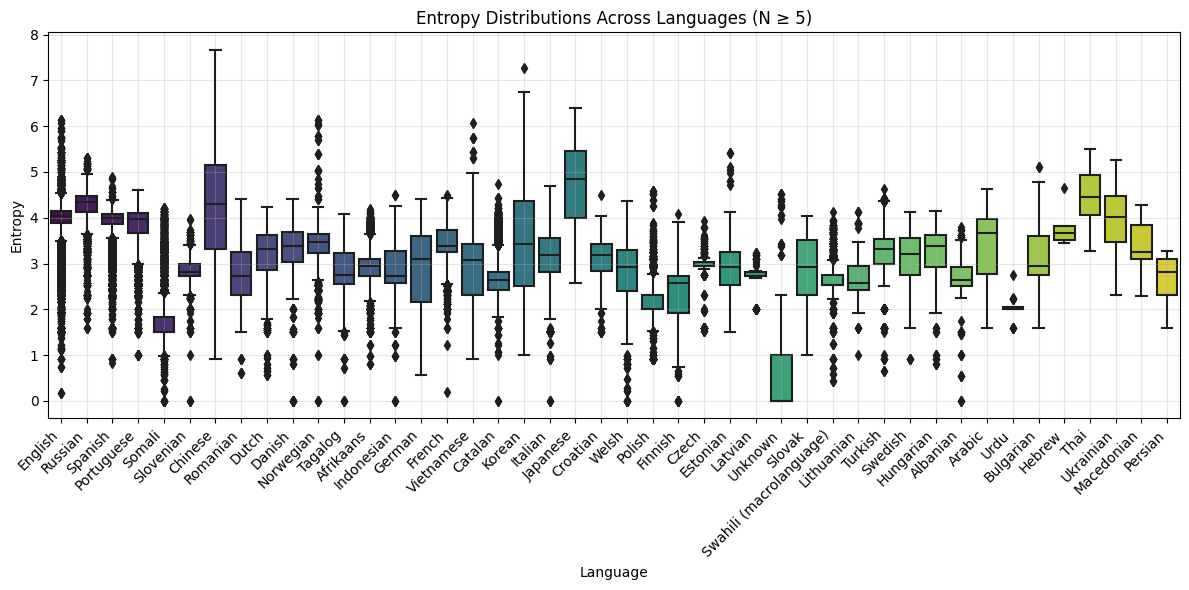


### Entropy Differences Across Languages
| Language | Samples (N) | Median Entropy | IQR | Differs From |
|----------|-------------|----------------|-----|--------------|
| English | 1,190,455 | 4.05 | 0.26 | Afrikaans, Albanian, Arabic, Bulgarian, Catalan, Chinese, Croatian, Czech, Danish, Dutch, Estonian, Finnish, French, German, Hungarian, Indonesian, Italian, Japanese, Korean, Latvian, Lithuanian, Macedonian, Norwegian, Persian, Polish, Portuguese, Romanian, Russian, Slovak, Slovenian, Somali, Spanish, Swahili (macrolanguage), Swedish, Tagalog, Thai, Turkish, Unknown, Urdu, Vietnamese, Welsh |
| Spanish | 98,361 | 4.00 | 0.21 | Afrikaans, Albanian, Arabic, Bulgarian, Catalan, Chinese, Croatian, Czech, Danish, Dutch, English, Estonian, Finnish, French, German, Hungarian, Indonesian, Italian, Japanese, Korean, Latvian, Lithuanian, Macedonian, Norwegian, Persian, Polish, Portuguese, Romanian, Russian, Slovak, Slovenian, Somali, Swahili (macrolanguage), Swedish, Tagalog, Thai, Turkish

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import scikit_posthocs as sp

def analyze_entropy_differences(df, language_col='language', entropy_col='entropy', min_samples=5):
    """
    Analyze differences in entropy across languages with non-normal distributions.
    Uses Kruskal-Wallis test, Dunn's post-hoc, box plots, and a Markdown table with test results.
    
    Parameters:
    - df: DataFrame with language and entropy columns
    - language_col: Column name for language (default: 'language')
    - entropy_col: Column name for entropy (default: 'entropy')
    - min_samples: Minimum number of reviews per language to analyze (default: 5)
    """
    # Count reviews per language and filter for sufficient samples
    language_counts = df[language_col].value_counts()
    valid_languages = language_counts[language_counts >= min_samples].index
    df_filtered = df[df[language_col].isin(valid_languages)].copy()
    
    if len(valid_languages) < 2:
        print(f"Need at least 2 languages with {min_samples}+ reviews for comparison.")
        return
    
    # Print summary of languages being analyzed
    print(f"Languages with {min_samples}+ Reviews:")
    print(language_counts[valid_languages])
    
    # Collect data for Markdown table
    table_data = []
    entropy_groups = [df_filtered[df_filtered[language_col] == lang][entropy_col].values 
                      for lang in valid_languages]
    
    # Kruskal-Wallis test
    h_stat, p_kruskal = stats.kruskal(*entropy_groups)
    print(f"\nKruskal-Wallis Test: H = {h_stat:.2f}, p-value = {p_kruskal:.4f}")
    
    # Dunn's post-hoc test if significant
    if p_kruskal < 0.05:
        print("Significant differences in entropy medians detected.")
        dunn_results = sp.posthoc_dunn(df_filtered, val_col=entropy_col, 
                                      group_col=language_col, p_adjust='bonferroni')
        print("\nDunn's Post-Hoc Test (Bonferroni corrected p-values):")
        print(dunn_results)
    else:
        print("No significant differences in entropy medians detected.")
        dunn_results = None
    
    # Analyze stats for each language
    for lang in valid_languages:
        entropy_data = df_filtered[df_filtered[language_col] == lang][entropy_col]
        n_samples = len(entropy_data)
        median_entropy = entropy_data.median()
        iqr_entropy = entropy_data.quantile(0.75) - entropy_data.quantile(0.25)
        
        # Summary stats
        print(f"\n{lang} Entropy Stats (N = {n_samples:,}):")
        print(entropy_data.describe())
        
        # Significant differences from Dunn's test
        if p_kruskal < 0.05 and dunn_results is not None:
            sig_diff = dunn_results.loc[lang, dunn_results.loc[lang] < 0.05].index.tolist()
            #sig_diff.remove(lang)  # Remove self-comparison
            if lang in sig_diff:
                sig_diff.remove(lang)
            diff_str = ", ".join(sig_diff) if sig_diff else "None"
        else:
            diff_str = "N/A (No significant overall difference)"
        
        # Add to table
        table_data.append([lang, n_samples, f"{median_entropy:.2f}", f"{iqr_entropy:.2f}", diff_str])
    
    # Box plot for visualization
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=language_col, y=entropy_col, data=df_filtered, palette='viridis')
    plt.title(f'Entropy Distributions Across Languages (N ≥ {min_samples})')
    plt.xlabel('Language')
    plt.ylabel('Entropy')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('entropy_boxplot.png', dpi=300, bbox_inches='tight')
    print("\nBox plot saved as 'entropy_boxplot.png'")
    plt.show()
    
    # Print Markdown table
    print("\n### Entropy Differences Across Languages")
    print("| Language | Samples (N) | Median Entropy | IQR | Differs From |")
    print("|----------|-------------|----------------|-----|--------------|")
    for row in table_data:
        print(f"| {row[0]} | {row[1]:,} | {row[2]} | {row[3]} | {row[4]} |")

analyze_entropy_differences(entropy_df)

In summary, we found that a number of our languages (we looked at ones with at least 10k reviews present) had statistically significant differences in median entropy using the Kruskal-Wallis test, a non-parametric alternative to ANOVA. This test was justified since the entropy distributions are not normally distributed (which we showed with QQ plots, the Anderson Darling test, and the skewness/kurtosis of the entropy distributions above).

This was somewhat expected since even the different structures of alphabets naturally cause differences is entropy between languages. But we wanted to confirm this and explore non-parametric inference techniques like this.